<a href="https://colab.research.google.com/github/Daybreak365/mischief-check/blob/master/%EC%9C%A0%ED%95%B4%EC%84%B1_%ED%8C%90%EB%8B%A8_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
%pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fe9e3a65ad0>)

In [3]:
train_data = pd.read_table('test.csv', sep='\t')
test_data = pd.read_table('dev.tsv', sep='\t')

In [4]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 13101


In [5]:
train_data[:5]

,comments,contain_gender_bias,bias,hate
0,게임 바둑이 노리터게임,False,none,none
1,죄인이존나ㅋㅋㅋㅋㅋ한남잼민이같아,False,none,hate
2,민주당 잡 것들 또 선동질 특검가자,False,none,hate
3,한남화됨,False,none,hate
4,너 그런게임해,False,none,none


In [6]:
print('테스트용 리뷰 개수 :',len(test_data))

테스트용 리뷰 개수 : 3548


In [7]:
test_data[:5]

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive


In [8]:
train_data['comments'].nunique(), train_data['hate'].nunique()

(13041, 2)

In [9]:
train_data.drop_duplicates(subset=['comments'], inplace=True)

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 13041


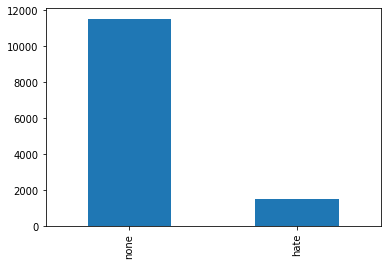

In [11]:
train_data['hate'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('hate').size().reset_index(name = 'count'))

   hate  count
0  hate   1520
1  none  11521


In [13]:
print(train_data.isnull().values.any())

False


In [14]:
print(train_data.isnull().sum())

comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [15]:
train_data.loc[train_data.comments.isnull()]

,comments,contain_gender_bias,bias,hate


In [16]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [17]:
print(len(train_data))

13041


In [18]:
train_data['comments'] = train_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,comments,contain_gender_bias,bias,hate
0,게임 바둑이 노리터게임,False,none,none
1,죄인이존나ㅋㅋㅋㅋㅋ한남잼민이같아,False,none,hate
2,민주당 잡 것들 또 선동질 특검가자,False,none,hate
3,한남화됨,False,none,hate
4,너 그런게임해,False,none,none


In [19]:
train_data['comments'] = train_data['comments'].str.replace('^ +', "")
train_data['comments'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

comments               0
contain_gender_bias    0
bias                   0
hate                   0
dtype: int64


In [20]:
train_data.loc[train_data.comments.isnull()][:5]

,comments,contain_gender_bias,bias,hate


In [21]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

13041


In [22]:
test_data.drop_duplicates(subset = ['comments'], inplace=True)
test_data['comments'] = test_data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['comments'] = test_data['comments'].str.replace('^ +', "")
test_data['comments'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 3540


In [23]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [24]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [25]:
X_train = []
for sentence in train_data['comments']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

In [26]:
print(X_train[:3])

[['게임', '바둑이', '노', '리터', '게임'], ['죄인', '존나', 'ㅋㅋㅋㅋㅋ', '한남', '잼민', '같다'], ['민주당', '잡', '것', '또', '선동', '질', '특검', '가다']]


In [27]:
X_test = []
for sentence in test_data['comments']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
print(tokenizer.word_index)

{'우파': 1, '스': 2, '애니': 3, '게임': 4, '한남': 5, '보다': 6, '책': 7, '날씨': 8, '나': 9, '아': 10, '문재인': 11, '오늘': 12, '민주당': 13, '다': 14, '을': 15, '좋다': 16, '이다': 17, '같다': 18, '요': 19, '진짜': 20, '오징어': 21, '아니다': 22, '안': 23, '야': 24, '틀': 25, '저': 26, '있다': 27, '딱': 28, '하': 29, '나오다': 30, '노엘': 31, '되다': 32, '로': 33, '만': 34, '읽다': 35, '없다': 36, '오다': 37, '네': 38, '님': 39, '내': 40, '뭐': 41, '너무': 42, '거': 43, '개': 44, '페미': 45, '왜': 46, '그': 47, '더힐': 48, '보고': 49, '취미': 50, '중': 51, '화': 52, '박근혜': 53, '에서': 54, '고': 55, '어': 56, 'ㅋㅋ': 57, '그렇다': 58, '게': 59, '재밌다': 60, '들다': 61, '가다': 62, '못': 63, '지': 64, '좌파': 65, '임': 66, '잇다': 67, '라': 68, '알다': 69, '랑': 70, '무슨': 71, '니': 72, '인': 73, '미치다': 74, '당': 75, '사람': 76, '일베': 77, '이야': 78, '싶다': 79, '자다': 80, '추천': 81, '날': 82, '지금': 83, '나다': 84, '오': 85, '해주다': 86, '일': 87, '또': 88, '헐다': 89, '새끼': 90, '근데': 91, '더': 92, '먹다': 93, '존나': 94, '하고': 95, '맞다': 96, 'ㅠ': 97, '해': 98, '어떻다': 99, '좋아하다': 100, '인데': 101, '지다': 102, '너': 103, '분': 

In [30]:
import json
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [31]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9897
등장 빈도가 2번 이하인 희귀 단어의 수: 7131
단어 집합에서 희귀 단어의 비율: 72.05213701121552
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.562295420365075


In [32]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2767


In [33]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [34]:
mapping = {'hate': 0, 'offensive': 0, 'none': 1}
y_train = np.array(list(map(lambda x: mapping[x], train_data['hate'])))
y_test = np.array(list(map(lambda x: mapping[x], test_data['hate'])))

In [35]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [36]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

12756
12756


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 4.648949513954218


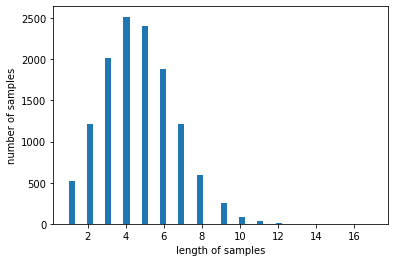

In [37]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [39]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [40]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [41]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [43]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=5, validation_split=0.2)

Epoch 1/15
2041/2041 [==============================] - 188s 86ms/step - loss: 0.2656 - acc: 0.9012 - val_loss: 0.1844 - val_acc: 0.8993

Epoch 00001: val_acc improved from -inf to 0.89929, saving model to best_model.h5
Epoch 2/15
  76/2041 [>.............................] - ETA: 2:43 - loss: 0.2330 - acc: 0.9184

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
loaded_model.save('my_model.h5')

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 해악성이 없는 댓글입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 해악성이 있는 댓글입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('')